# Preparação da Base 

## 1 - Bibliotecas e dados

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import seaborn as sns
import sklearn
import requests
import csv
import re
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
df = pd.read_csv('desafio_indicium_imdb.csv')

In [61]:
df.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


## 2 - Adicionando Dados Externos

Alguns dados que não foram fornecidos nessa base inicial me parecem importantes:

- Custo da produção (Budget)
- Data de lançamento (mês e dia)
O primeiro vai ajudar a entender como o ROI se comporta, e o segundo pode mostrar alguma sazonalidade (filmes de romance no dia dos namorados, filmes infantis nas férias escolares, filmes de terror no halloween etc)

A lista parece ser o top 1000 do IMDB, sem o top 1 que foi retirado como exemplo para o tópico 5 do desafio, infelizmente a API do IMDB é paga desde 2023, então vou recorrer ao TMDB que tem uma API pública
Vou usar essa API para coletar o maximo de dabos possíveis e ver o que posso extrair para incrementar a base fornecida

In [ ]:
api_key = 'ed7763b268797ae60379d1098090246a'
base_url = 'https://api.themoviedb.org/3/search/movie'
output_file = 'tmdb_filmes_encontrados_parallel.csv'
max_workers = 5  
timeout = 5      

df.columns = df.columns.str.strip()
titles = df['Series_Title'].tolist()

header_written = False
fieldnames = None

def fetch_movie(title):
    retries = 0
    wait = 1
    while retries < 5:
        try:
            params = {
                'api_key': api_key,
                'query': title,
                'with_original_language': 'en'
            }
            response = requests.get(base_url, params=params, timeout=timeout)
            data = response.json()
            
            if 'results' in data and len(data['results']) > 0:
                return data['results'][0]  
            else:
                return None
        except Exception as e:
            retries += 1
            time.sleep(wait)
            wait *= 2  # backoff exponencial para evitar sobrecarga
    return None

def save_to_csv(movie):
    global header_written, fieldnames
    if movie:
        if not header_written:
            fieldnames = movie.keys()
            with open(output_file, 'w', newline='', encoding='utf-8') as f:
                writer = csv.DictWriter(f, fieldnames=fieldnames)
                writer.writeheader()
            header_written = True
        with open(output_file, 'a', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writerow(movie)

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    future_to_title = {executor.submit(fetch_movie, title): title for title in titles}
    for future in as_completed(future_to_title):
        movie = future.result()
        save_to_csv(movie)
        print(f"Salvo: {movie['title'] if movie else 'Não encontrado'}")


Salvo: The Godfather
Salvo: The Lord of the Rings: The Return of the King
Salvo: The Godfather Part II
Salvo: The Dark Knight
Salvo: 12 Angry Men
Salvo: Pulp Fiction
Salvo: Inception
Salvo: Schindler's List
Salvo: The Lord of the Rings: The Fellowship of the Ring
Salvo: Fight Club
Salvo: Forrest Gump
Salvo: The Good, the Bad and the Ugly
Salvo: The Lord of the Rings: The Two Towers
Salvo: GoodFellas
Salvo: The Matrix
Salvo: The Empire Strikes Back
Salvo: One Flew Over the Cuckoo's Nest
Salvo: Parasite
Salvo: Hamilton
Salvo: Soorarai Pottru
Salvo: Interstellar
Salvo: Spirited Away
Salvo: City of God
Salvo: Saving Private Ryan
Salvo: The Green Mile
Salvo: Life Is Beautiful
Salvo: Se7en
Salvo: The Silence of the Lambs
Salvo: Star Wars
Salvo: Seppuku
Salvo: It's a Wonderful Life
Salvo: Joker
Salvo: Seven Samurai
Salvo: Whiplash
Salvo: The Intouchables
Salvo: The Departed
Salvo: The Prestige
Salvo: The Pianist
Salvo: Gladiator
Salvo: American History X
Salvo: Léon: The Professional
Salvo: T

In [3]:
df_externo = pd.read_csv('tmdb_filmes_encontrados_parallel.csv')

In [4]:
df_merged = df.merge(
    df_externo[['original_title', 'release_date']], 
    left_on='Series_Title',   
    right_on='original_title', 
    how='left'  
)

df_merged = df_merged.drop(columns=['original_title'])

O merge gerou três linhas a mais, vou retirá-las

In [5]:
chaves_para_manter = df_merged['Series_Title'].unique()

df_filtrado = df_merged[df_merged['Series_Title'].isin(chaves_para_manter)]


df_filtrado = df_filtrado.drop_duplicates(subset=['Series_Title'], keep='first')

print(f"Número de linhas antes da remoção de duplicatas: {len(df_filtrado)}")
print(f"Número de linhas após a remoção de duplicatas: {len(df_filtrado)}")

Número de linhas antes da remoção de duplicatas: 998
Número de linhas após a remoção de duplicatas: 998


In [139]:
df_filtrado.shape

(998, 17)

In [6]:
df_filtrado['release_date'] = pd.to_datetime(df_filtrado['release_date'], errors='coerce')
df_filtrado['Released_Month'] = df_filtrado['release_date'].dt.month
df_filtrado['Released_Day'] = df_filtrado['release_date'].dt.day

In [7]:
cols = list(df_filtrado.columns)

pos = cols.index('Released_Year')

# Ordenar as colunas de mês e dia de lançamento junto com a do ano
for i, col in enumerate(['Released_Month', 'Released_Day']):
    cols.insert(pos + 1 + i, cols.pop(cols.index(col)))

df_ordenado = df_filtrado[cols]

A API de TMDB ajudou com as datas mas não tinha os dados de budget, então vou recorrer a um dataframe do Kaggle, chamado Full TMDB Movies Dataset, tem mais de 1mi filmes e tem os dados de budget
Ele está disponível em https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies

In [10]:
df_kaggle = pd.read_csv('TMDB_movie_dataset_v11.csv')

In [11]:
df_ordenado['Series_Title_clean'] = df_ordenado['Series_Title'].str.lower().str.strip()
df_kaggle['title_clean'] = df_kaggle['title'].str.lower().str.strip()

df_kaggle_subset = df_kaggle[['title_clean', 'budget']]

df_kaggle_unique = df_kaggle_subset.drop_duplicates(subset=['title_clean'], keep='first')

df_merged_kaggle = df_ordenado.merge(
    df_kaggle_unique,
    left_on='Series_Title_clean',
    right_on='title_clean',
    how='left'
).drop(columns=['title_clean', 'Series_Title_clean'])

C:\Users\User\AppData\Local\Temp\ipykernel_18444\283482880.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ordenado['Series_Title_clean'] = df_ordenado['Series_Title'].str.lower().str.strip()


In [151]:
df_merged_kaggle.head()

,Unnamed: 0,Series_Title,Released_Year,Released_Month,Released_Day,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,release_date,budget
0,1,The Godfather,1972,3.0,14.0,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411",1972-03-14,6000000.0
1,2,The Dark Knight,2008,7.0,16.0,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444",2008-07-16,185000000.0
2,3,The Godfather: Part II,1974,NaN,NaN,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000",NaT,NaN
3,4,12 Angry Men,1957,4.0,10.0,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000",1957-04-10,350000.0
4,5,The Lord of the Rings: The Return of the King,2003,12.0,17.0,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905",2003-12-17,94000000.0


In [12]:
num_nan = df_merged_kaggle['budget'].isna().sum()
print(num_nan)

191


O número de NAs está muito alto nessa coluna, vou tentar usar mais uma base de dados e ver se consigo reduzir os missings. Dessa vez vou usar o The Movie Dataset (https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?utm_source=chatgpt.com)

In [13]:
df_kaggle2 = pd.read_csv('movies_metadata.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_18444\3001269364.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_kaggle2 = pd.read_csv('movies_metadata.csv')


In [14]:
df_merged_kaggle['Series_Title_clean'] = df_merged_kaggle['Series_Title'].str.lower().str.strip()
df_kaggle2['original_title_clean'] = df_kaggle2['original_title'].str.lower().str.strip()

title_to_budget = df_kaggle2.set_index('original_title_clean')['budget'].to_dict()

df_merged_kaggle['budget'] = df_merged_kaggle['budget'].fillna(df_merged_kaggle['Series_Title_clean'].map(title_to_budget))

df_merged_kaggle2 = df_merged_kaggle.drop(columns=['Series_Title_clean'])

In [15]:
num_nan = df_merged_kaggle2['budget'].isna().sum()
print(num_nan)

112


O número de missings caiu quase pela metade, o restante será tratado mais adiante

In [16]:
def clean_numeric(x):
    if pd.isna(x):
        return None
    x = str(x)
    x = re.sub(r'[^0-9]', '', x)
    return int(x) if x else None

df_merged_kaggle2['budget'] = df_merged_kaggle2['budget'].apply(clean_numeric)
df_merged_kaggle2['Gross'] = df_merged_kaggle2['Gross'].apply(clean_numeric)

In [17]:
# Corrigindo o budget já que estava sempre com um zero extra
df_merged_kaggle2['budget'] = df_merged_kaggle2['budget'] / 10

df_merged_kaggle2['ROI'] = (df_merged_kaggle2['Gross'] - df_merged_kaggle2['budget']) / df_merged_kaggle2['budget']

df_merged_kaggle2.loc[df_merged_kaggle2['budget'].isna() | (df_merged_kaggle2['budget'] == 0), 'ROI'] = None

## 3 - Preparação para EDA

In [26]:
df_merged_kaggle2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 997
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      998 non-null    int64         
 1   Series_Title    998 non-null    object        
 2   Released_Year   997 non-null    Int64         
 3   Released_Month  782 non-null    Int64         
 4   Released_Day    782 non-null    Int64         
 5   Certificate     897 non-null    object        
 6   Runtime         998 non-null    Int64         
 7   Genre           998 non-null    object        
 8   IMDB_Rating     998 non-null    float64       
 9   Overview        998 non-null    object        
 10  Meta_score      842 non-null    float64       
 11  Director        998 non-null    object        
 12  Star1           998 non-null    object        
 13  Star2           998 non-null    object        
 14  Star3           998 non-null    object        
 15  Star4 

In [18]:
df_merged_kaggle2['Released_Year'] = pd.to_numeric(df_merged_kaggle2['Released_Year'], errors='coerce').astype('Int64')

df_merged_kaggle2['Released_Month'] = df_merged_kaggle2['Released_Month'].astype('Int64')
df_merged_kaggle2['Released_Day'] = df_merged_kaggle2['Released_Day'].astype('Int64')

df_merged_kaggle2['Runtime'] = df_merged_kaggle2['Runtime'].str.replace(' min', '', regex=False).astype('Int64')


Vou verificar a distribuição de Gross e No_of_Votes
Esse é um tipo de variável que pode ter uma assimetria muito grande, pedindo uma transformação logarítimica

In [22]:
df_merged_kaggle2[['Gross', 'No_of_Votes', 'budget', 'ROI']].describe()

,Gross,No_of_Votes,budget,ROI
count,8.290000e+02,9.980000e+02,8.860000e+02,667.000000
mean,6.816381e+07,2.718231e+05,2.791443e+07,109.241097
std,1.098489e+08,3.210102e+05,4.919383e+07,1881.500844
min,1.305000e+03,2.508800e+04,0.000000e+00,-0.999923
25%,3.270000e+06,5.541675e+04,1.000000e+06,0.096871
50%,2.353089e+07,1.385485e+05,7.000000e+06,1.260203
75%,8.100179e+07,3.735062e+05,2.900000e+07,3.995639
max,9.366622e+08,2.303232e+06,3.560000e+08,41321.650000


Analisando as estatísticas descritivas podemos observar que ambas as variávéis são assimétricas para a direita, ou seja, muitos dos filmes tem um valor mediano ou baixo,
e alguns poucos outliers com valores enormes. Abaixo vou mostrar um boxplot dessas duas variáveis, o primeiro é copm as variáveis "cruas" e o segundo com elas em Log, 
com uma vizualização bem melhor por corrigir o problema de assimetria para a direita.

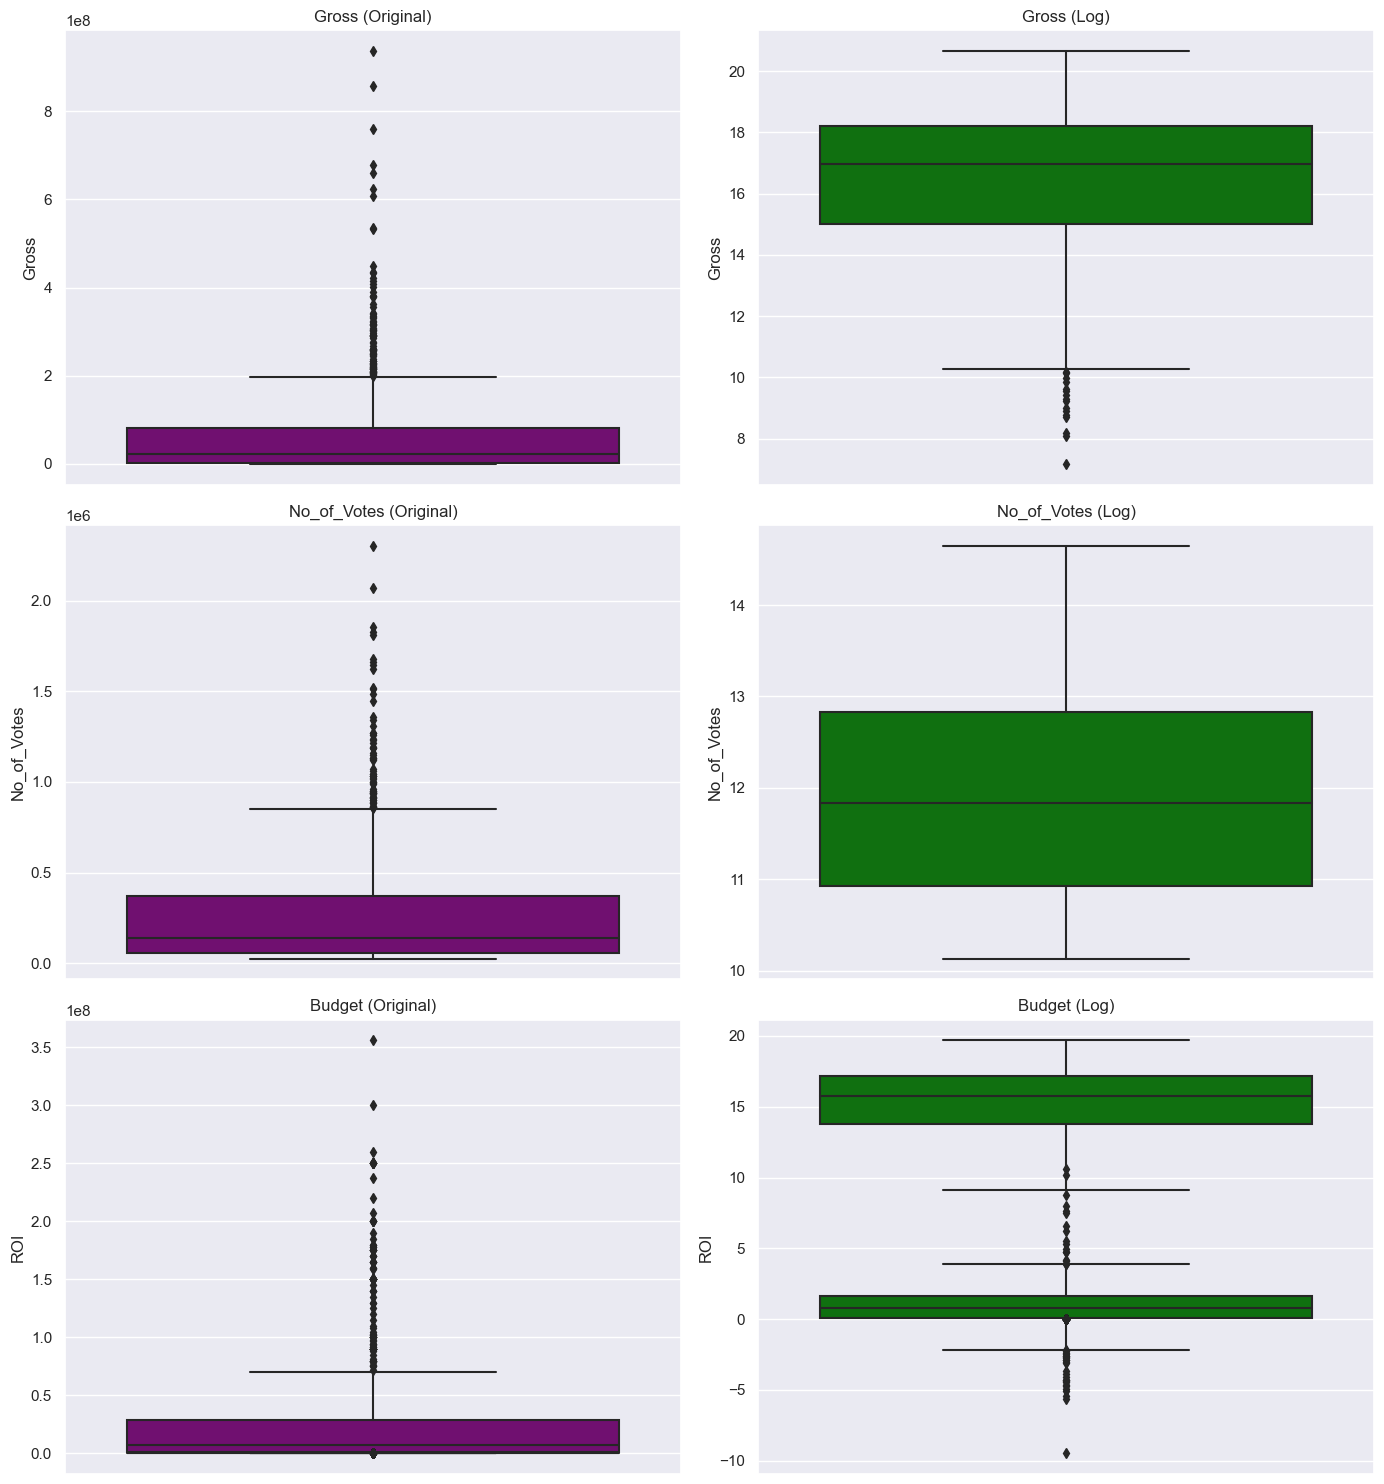

In [ ]:
sns.set(style="darkgrid")

fig, axes = plt.subplots(3, 2, figsize=(14, 15))  

# Gross
sns.boxplot(y=df_merged_kaggle2['Gross'], ax=axes[0,0], color='purple')
axes[0,0].set_title('Gross (Original)')

sns.boxplot(y=np.log1p(df_merged_kaggle2['Gross']), ax=axes[0,1], color='green')
axes[0,1].set_title('Gross (Log)')

# No_of_Votes
sns.boxplot(y=df_merged_kaggle2['No_of_Votes'], ax=axes[1,0], color='purple')
axes[1,0].set_title('No_of_Votes (Original)')

sns.boxplot(y=np.log1p(df_merged_kaggle2['No_of_Votes']), ax=axes[1,1], color='green')
axes[1,1].set_title('No_of_Votes (Log)')

# Budget
sns.boxplot(y=df_merged_kaggle2['budget'], ax=axes[2,0], color='purple')
axes[2,0].set_title('Budget (Original)')

sns.boxplot(y=np.log1p(df_merged_kaggle2['budget']), ax=axes[2,1], color='green')
axes[2,1].set_title('Budget (Log)')

# ROI
sns.boxplot(y=df_merged_kaggle2['ROI'], ax=axes[2,0], color='purple')
axes[2,0].set_title('Budget (Original)')

sns.boxplot(y=np.log1p(df_merged_kaggle2['ROI']), ax=axes[2,1], color='green')
axes[2,1].set_title('Budget (Log)')

plt.tight_layout()
plt.show()

In [27]:
df_EDA = df_merged_kaggle2.copy()

df_EDA['Gross_log'] = np.log1p(df_EDA['Gross'])
df_EDA['No_of_Votes_log'] = np.log1p(df_EDA['No_of_Votes'])
df_EDA['budget_log'] = np.log1p(df_EDA['budget'])
df_EDA['ROI_log'] = np.log1p(df_EDA['ROI'])

In [28]:
df_EDA.to_csv("df_EDA.csv", index=False, encoding="utf-8")